In [8]:
# import
import os

import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [9]:
base_path = 'archive/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255., validation = 0.9)
image_size = (224,224)
batch_size = 64

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    image_size,
    batch_size=64,
    class_mode='binary'
    subset = 'training'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    image_size,
    batch_size=64,
    class_mode='binary'
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [10]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)


model = Sequential([
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])
    
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['acc']
)


In [11]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [12]:
train_steps = 400//64
valid_steps = 80//64

history = model.fit_generator(
    train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps
)

Epoch 1/10
6/6 [==============================] - 161s 27s/step - loss: 0.9426 - acc: 0.5104 - val_loss: 0.6935 - val_acc: 0.4844
Epoch 2/10
6/6 [==============================] - 160s 27s/step - loss: 0.7493 - acc: 0.5469 - val_loss: 0.7039 - val_acc: 0.5156
Epoch 3/10
6/6 [==============================] - 157s 26s/step - loss: 0.7045 - acc: 0.5286 - val_loss: 0.6975 - val_acc: 0.5156
Epoch 4/10
6/6 [==============================] - 161s 27s/step - loss: 0.7317 - acc: 0.5130 - val_loss: 0.7314 - val_acc: 0.5000
Epoch 5/10
6/6 [==============================] - 163s 27s/step - loss: 0.6807 - acc: 0.5651 - val_loss: 0.8775 - val_acc: 0.5000
Epoch 6/10
6/6 [==============================] - 156s 26s/step - loss: 0.7143 - acc: 0.5130 - val_loss: 0.7000 - val_acc: 0.4531
Epoch 7/10
6/6 [==============================] - 157s 26s/step - loss: 0.7163 - acc: 0.5703 - val_loss: 0.7084 - val_acc: 0.5000
Epoch 8/10
6/6 [==============================] - 157s 26s/step - loss: 0.7242 - acc: 0.52

In [13]:
#model.save('completed_trained_model.h5')

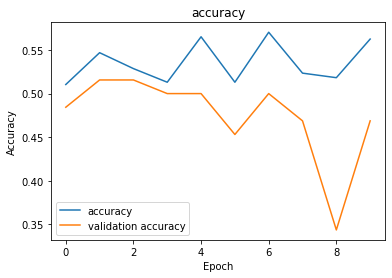

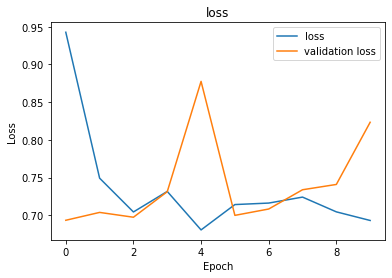

In [21]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'validation accuracy')
plt.title('accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

#Loss
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.title('loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [17]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(base_path,target_size=image_size,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 140000 images belonging to 3 classes.
140000
Instructions for updating:
Please use Model.evaluate, which supports generators.
   426/140000 [..............................] - ETA: 2:20:36 - loss: 1.1001 - acc: 0.1268

KeyboardInterrupt: 

In [ ]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [ ]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

In [ ]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=custom_vgg_model.input,
                                        outputs=custom_vgg_model.get_layer('dense2').output)

tsne_eval_generator = test_datagen.flow_from_directory(base_path,target_size=image_size,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

    
pred = intermediate_layer_model.predict_generator(tsne_eval_generator,270,verbose=1)
print(pred.shape)
features = TSNE(n_components=2).fit_transform(pred)
print(features.shape)

x1,x2,y1,y2 = [],[],[],[]
cls = tsne_eval_generator.classes
for i in range(len(features)):
    if cls[i] == 0: 
        x1.append(features[i, 0])
        y1.append(features[i, 1])    
    else:
        x2.append(features[i, 0])
        y2.append(features[i, 1])

plt.figure()
plt.plot(x1, y1, 'ro', label="real")
plt.plot(x2, y2, 'bo', label="fake")
plt.legend(loc='upper right')